In [87]:
from astropy.io import ascii, fits
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob, os
import astropy.constants as const
import matplotlib.axes as maxes
from mpl_toolkits.axes_grid1 import make_axes_locatable

c = const.c.cgs.value

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # make the figure resolution matching the Mac retina resolution

# Plot formatting function

In [88]:
def publish(fig=None, ax=None, figsize=(8,6), cb=None, labelsize=16, 
            ticksize=16, legend_fontsize=14, frame_lw=1.5, lw=1.5,
            minorticks='x,y', useoffset=False):
    import matplotlib.pyplot as plt

    if fig == None:
        fig = plt.gcf()

    fig.patch.set_facecolor('white')
    fig.set_figwidth(figsize[0])
    fig.set_figheight(figsize[1])

    if ax == None:
        ax = fig.gca()

    # lines
    if lw != None:
        for line in ax.get_lines():
            plt.setp(line, lw=lw)

    # axis
#     ax.minorticks_on()
    if 'x' in minorticks:
        ax.tick_params(axis='x', which='minor', bottom=True)
    if 'y' in minorticks:
        ax.tick_params(axis='y', which='minor', left=True)
        ax.tick_params(axis='y', which='minor', right=True)
    [ax.spines[axis].set_linewidth(frame_lw)
     for axis in ['top', 'bottom', 'left', 'right']]
    ax.tick_params('both', labelsize=ticksize, width=frame_lw,
                   which='major', pad=5, length=5)
    ax.tick_params('both', labelsize=ticksize, width=frame_lw,
                   which='minor', pad=5, length=4)
    if useoffset != None:
        ax.ticklabel_format(useOffset=useoffset)

    # label
    ax.xaxis.label.set_fontsize(labelsize)
    ax.yaxis.label.set_fontsize(labelsize)

    # legend
    if ax.get_legend() != None:
        plt.setp(ax.get_legend().get_texts(), fontsize=legend_fontsize)

    # colorbar
    if cb != None:
        cb.ax.yaxis.label.set_fontsize(labelsize)
        cb.ax.tick_params('both', labelsize=ticksize,
                          width=frame_lw, which='major', pad=5, length=5)
        cb.outline.set_linewidth(frame_lw)

    return fig, ax


# Open the spectral cube - RED

In [130]:
hdu = fits.open('/Users/cassiopeia/Downloads/fits/F0740_FI_IFS_09016939_RED_WXY_00055-00104.fits')
print (hdu[0].header['OBJECT'], '{:<.1f} um'.format(hdu[1].header['CRVAL3']))

NGC_7538_IRS_9 145.0 um


## Print out the extensions

In [131]:
for i in range(1, 12):
    print(i, hdu[i].header['EXTNAME'])

1 FLUX
2 ERROR
3 UNCORRECTED_FLUX
4 UNCORRECTED_ERROR
5 WAVELENGTH
6 X
7 Y
8 TRANSMISSION
9 RESPONSE
10 EXPOSURE_MAP
11 UNSMOOTHED_TRANSMISSION


## Redo the spectral cube (for 63 um)

In [132]:
if abs(hdu[1].header['CRVAL3']-63) < 5:

    cube = hdu[3].data  # redo the transmission correction
    trans = hdu[8].data
    mod_cube = np.zeros_like(cube)
    for i in range(len(cube[:,0,0])):
        mod_cube[i,:,:] = cube[i,:,:]/trans[i]
else:
    mod_cube = hdu[1].data
    trans = hdu[8].data

# Make a quick look of the spectrum

## 145 um

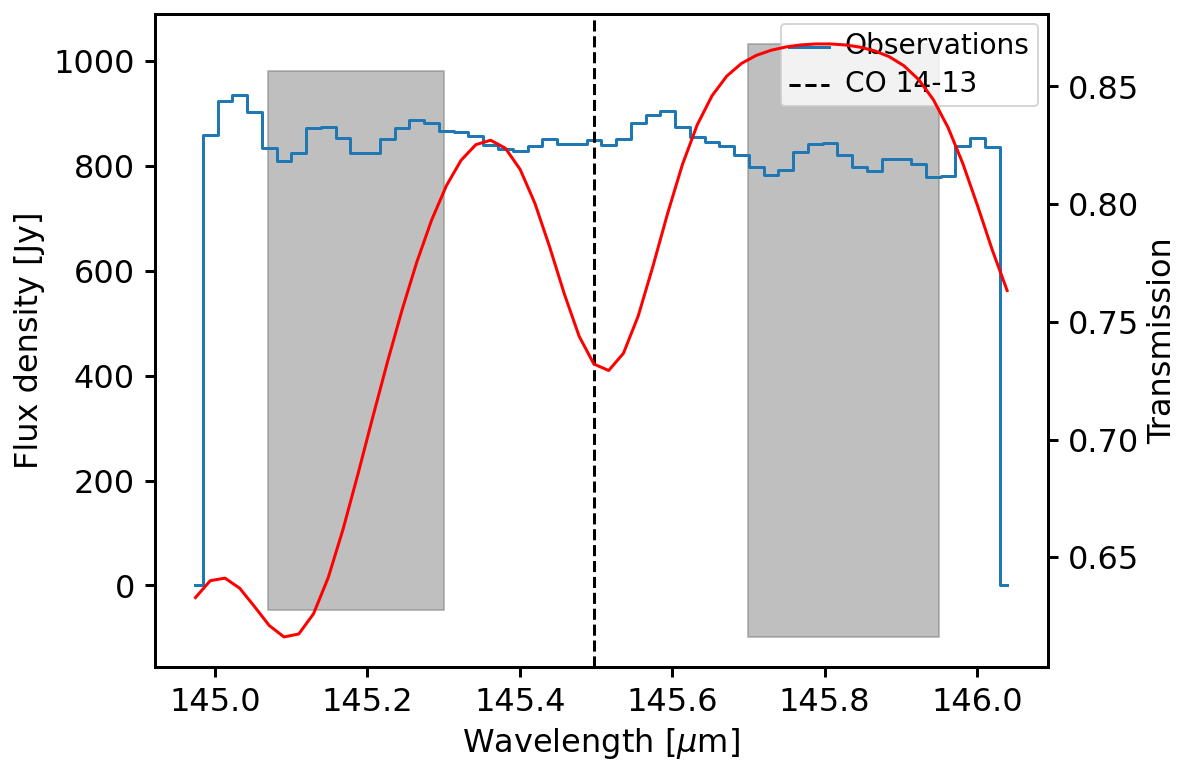

In [133]:
# Construct the flux/wavelength array
wave = ((np.arange(hdu[1].header['NAXIS3'])+1)-hdu[1].header['CRPIX3']) * hdu[1].header['CDELT3'] + hdu[1].header['CRVAL3']

line_freq = 2.06006909e12
#line_freq = 1.6117935180e12
v_source = -57 # km/s (Sandell+2015)
line_wave = c/line_freq * 1e4
line_wave_v_source = line_wave * (1+v_source/c*1e5)

fig = plt.figure()
ax = fig.add_subplot(111)

n_pixel = mod_cube.shape[1]
ax.plot(wave, np.nansum(np.nansum(mod_cube[:,n_pixel//2-4:n_pixel//2+4, n_pixel//2-4:n_pixel//2+4], axis=1), axis=1), drawstyle='steps-mid', label='Observations')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel('Flux density [Jy]')
ax.axvline(line_wave_v_source, color='k', linestyle='--', label='CO 14-13')

# choose the continuum range
ax.fill_betweenx(ax.get_ylim(), 145.07, 145.3, color='Gray', alpha=0.5)
ax.fill_betweenx(ax.get_ylim(), 145.7, 145.95, color='Gray', alpha=0.5)
ax.legend(loc='best')
fig, ax = publish(fig)

ax2 = ax.twinx()
ax2.plot(wave, trans, label='Transmission', color='r')
ax2.set_ylabel('Transmission')
fig, ax2 = publish(fig, ax=ax2)

In [134]:
cont_regions = [[145.07, 145.3], [145.7, 145.95]] # NGC 7538 IRS9

<div class="alert alert-block alert-info">
Need to double check wuth SOSPEX to see if we can get a line-free spectrum
</div>



# Make continuum (line-free) image

In [135]:
selector = np.zeros_like(wave, dtype='bool')

for _region in cont_regions:
    selector += (wave >= _region[0]) & (wave <= _region[1])
cont_im_red = np.nanmean(hdu[1].data[selector,:,:], axis=0)

<ipython-input-135-7f5c578b9be9>:5: RuntimeWarning: Mean of empty slice
  cont_im_red = np.nanmean(hdu[1].data[selector,:,:], axis=0)


## Continuum image without astrometric correction

<ipython-input-136-fbf19f5e6dc3>:38: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)


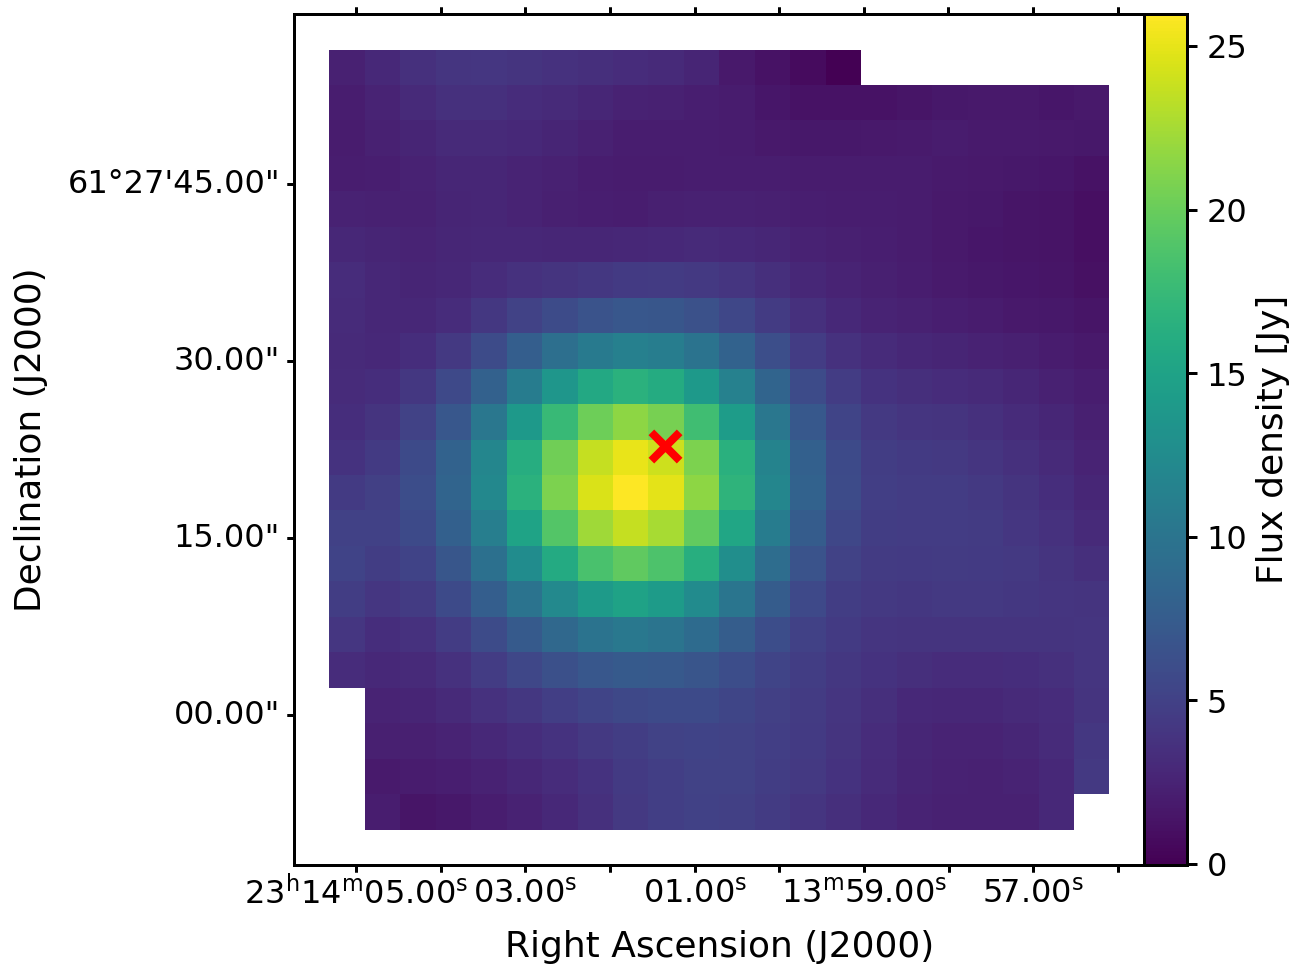

In [136]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS

w = WCS(naxis=2)
w.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
w.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
w.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
w.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

s = SkyCoord('23:14:01.77 61:27:19.8', unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

im = ax.imshow(cont_im_red)

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)


ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)

# cax = fig.add_axes([0.9,0.125,0.03,0.755])
# cb=fig.colorbar(im, cax=cax)
# cb.solids.set_rasterized(True)
# cb.solids.set_edgecolor("face")

cb.ax.set_ylabel('Flux density [Jy]', fontsize=18)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
_ = plt.setp(cb_obj,fontsize=16)

# Fit with a 2D Gaussian

x_mean = -0.792 +/- 0.039
y_mean = -1.327 +/- 0.036


<ipython-input-137-ead385a578a9>:51: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)


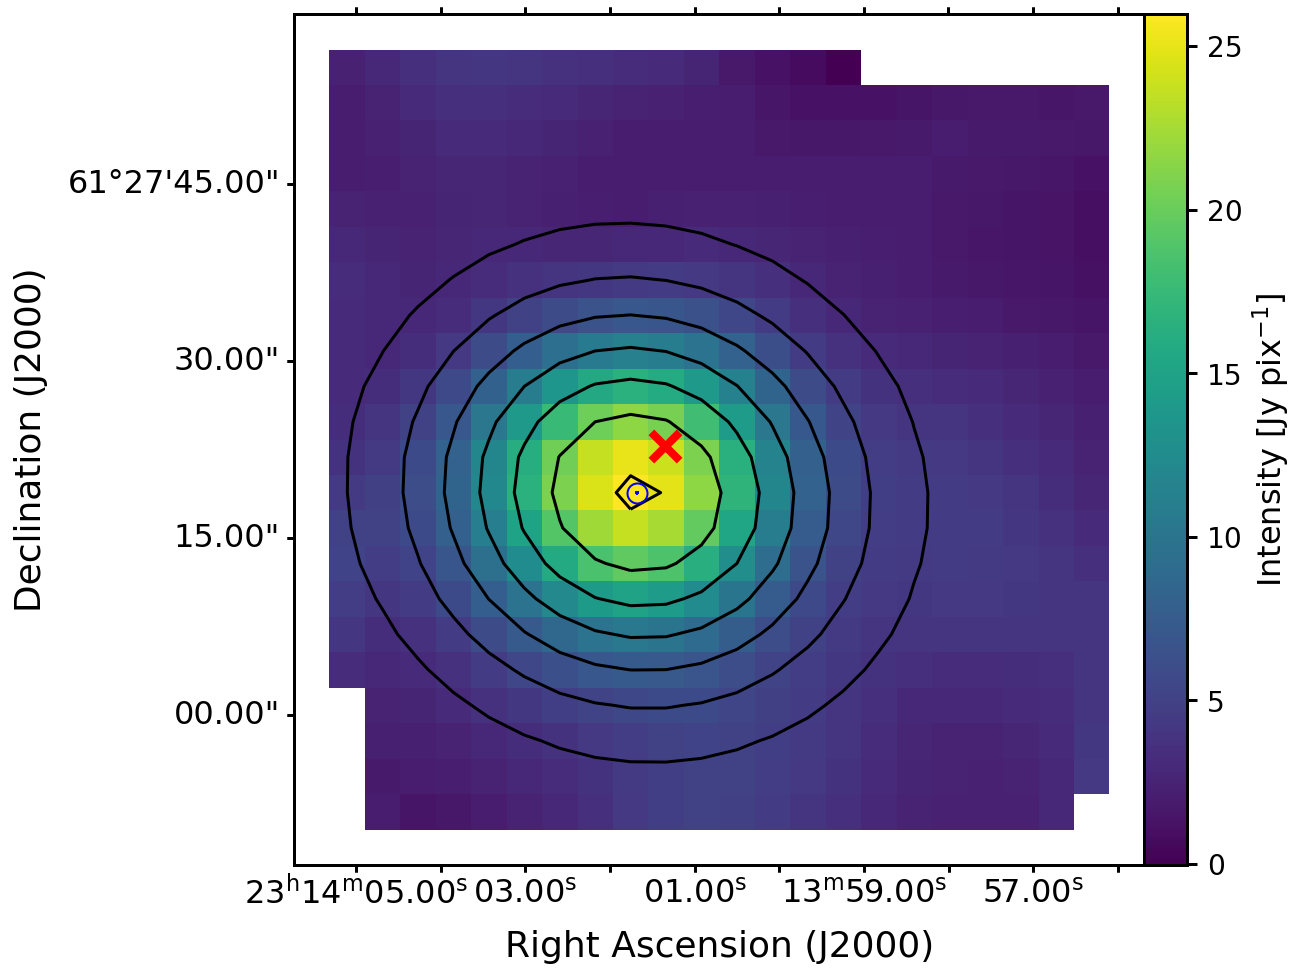

In [137]:
import astropy.io.fits as fits
import os
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 

fit = fitting.LevMarLSQFitter()
# initial guess of the fitting parameters
m = models.Gaussian2D(np.nanmax(cont_im_red), 0, 0, 2, 2)

# Create grids of x- and y-pixels
# Have the source coordinate in here as well, just to be safe
s = SkyCoord('23:14:01.77 61:27:19.8', unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

x_grid, y_grid = np.meshgrid(np.arange(len(cont_im_red[0,:])), np.arange(len(cont_im_red[:,0])))
dist_grid = ((x_grid-s_pix[0])**2 + (y_grid-s_pix[1])**2)**0.5
xi = x_grid-s_pix[0]
yi = y_grid-s_pix[1]

# fitting - set NaN value to zero
g = fit(m, xi, yi, np.where(~np.isnan(cont_im_red), cont_im_red, 0.0))
# print(g)
print( 'x_mean = {:<.3f} +/- {:<.3f}'.format(g.x_mean.value, fit.fit_info['cov_x'][1,1]**0.5) )
print( 'y_mean = {:<.3f} +/- {:<.3f}'.format(g.y_mean.value, fit.fit_info['cov_x'][2,2]**0.5) )
model_data = g(xi, yi)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

ax.imshow(cont_im_red)
ax.contour(model_data, colors='k')
ax.errorbar(g.x_mean.value+s_pix[0], g.y_mean.value+s_pix[1], 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)

ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

## Calculate the offset

In [138]:
from astropy.wcs import utils


x_offset_red, y_offset_red = [g.x_mean.value, g.y_mean.value] # in pixel
x_offset_err_red, y_offset_err_red = [fit.fit_info['cov_x'][1,1]**0.5, fit.fit_info['cov_x'][2,2]**0.5]
pltscale = utils.proj_plane_pixel_scales(w) # width of a pixel in degree
x_offset_arcsec, y_offset_arcsec = [x_offset_red*pltscale[0]*3600, y_offset_red*pltscale[0]*3600]
x_offset_err_arcsec, y_offset_err_arcsec = [x_offset_err_red*pltscale[0]*3600, y_offset_err_red*pltscale[0]*3600]

# Recall that RA goes from positivie to negative from left to right
print('Offset in x and y (arcsec, arcsec) = ({:<.2f}+/-{:<.2f}, {:<.2f}+/-{:<.2f})'.format(x_offset_arcsec, x_offset_err_arcsec, 
                                                                                           y_offset_arcsec, y_offset_err_arcsec))

# save the offset
x_offset_red_arcsec = x_offset_arcsec
y_offset_red_arcsec = y_offset_arcsec
x_offset_err_red_arcsec = x_offset_err_arcsec
y_offset_err_red_arcsec = y_offset_err_arcsec

Offset in x and y (arcsec, arcsec) = (-2.37+/-0.12, -3.98+/-0.11)


## Continuum image WITH astrometric correction

<ipython-input-139-84ea815eca6f>:50: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)


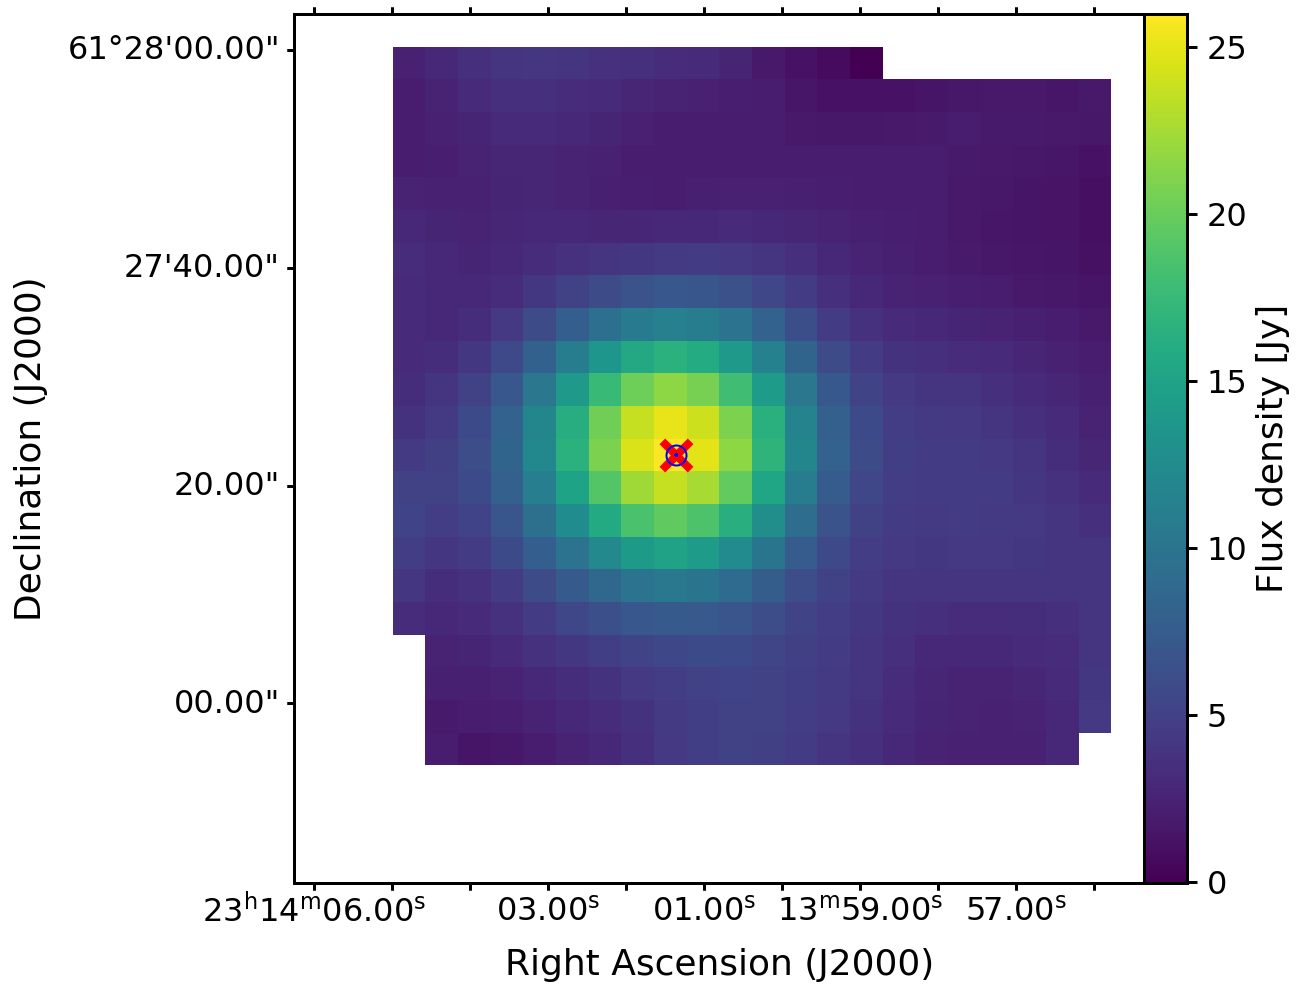

In [139]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from scipy.ndimage import shift

w = WCS(naxis=2)
w.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
w.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
w.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
w.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

s = SkyCoord('23:14:01.77 61:27:19.8', unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

# make an image with correction to get the extent
im = ax.imshow(cont_im_red)
extent = im.get_extent()
# reset the extent with astrometric correction
im.set_extent([extent[0]-x_offset_red, extent[1]-x_offset_red, 
                       extent[2]-y_offset_red, extent[3]-y_offset_red])

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

# source position
ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

# where the peak of the 2D gaussian supposed to be
ax.errorbar(g.x_mean.value+s_pix[0]-x_offset_red, g.y_mean.value+s_pix[1]-y_offset_red, 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)

cb.ax.set_ylabel('Flux density [Jy]', fontsize=18)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
_ = plt.setp(cb_obj,fontsize=16)

# Make cont-free spectral cube

In [140]:
# cube = hdu[3].data  # redo the transmission correction
contsub_cube = np.zeros_like(mod_cube)
for i in range(len(mod_cube[:,0,0])):
    contsub_cube[i,:,:] = mod_cube[i,:,:] - cont_im_red

<ipython-input-141-d723d57ce695>:54: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)


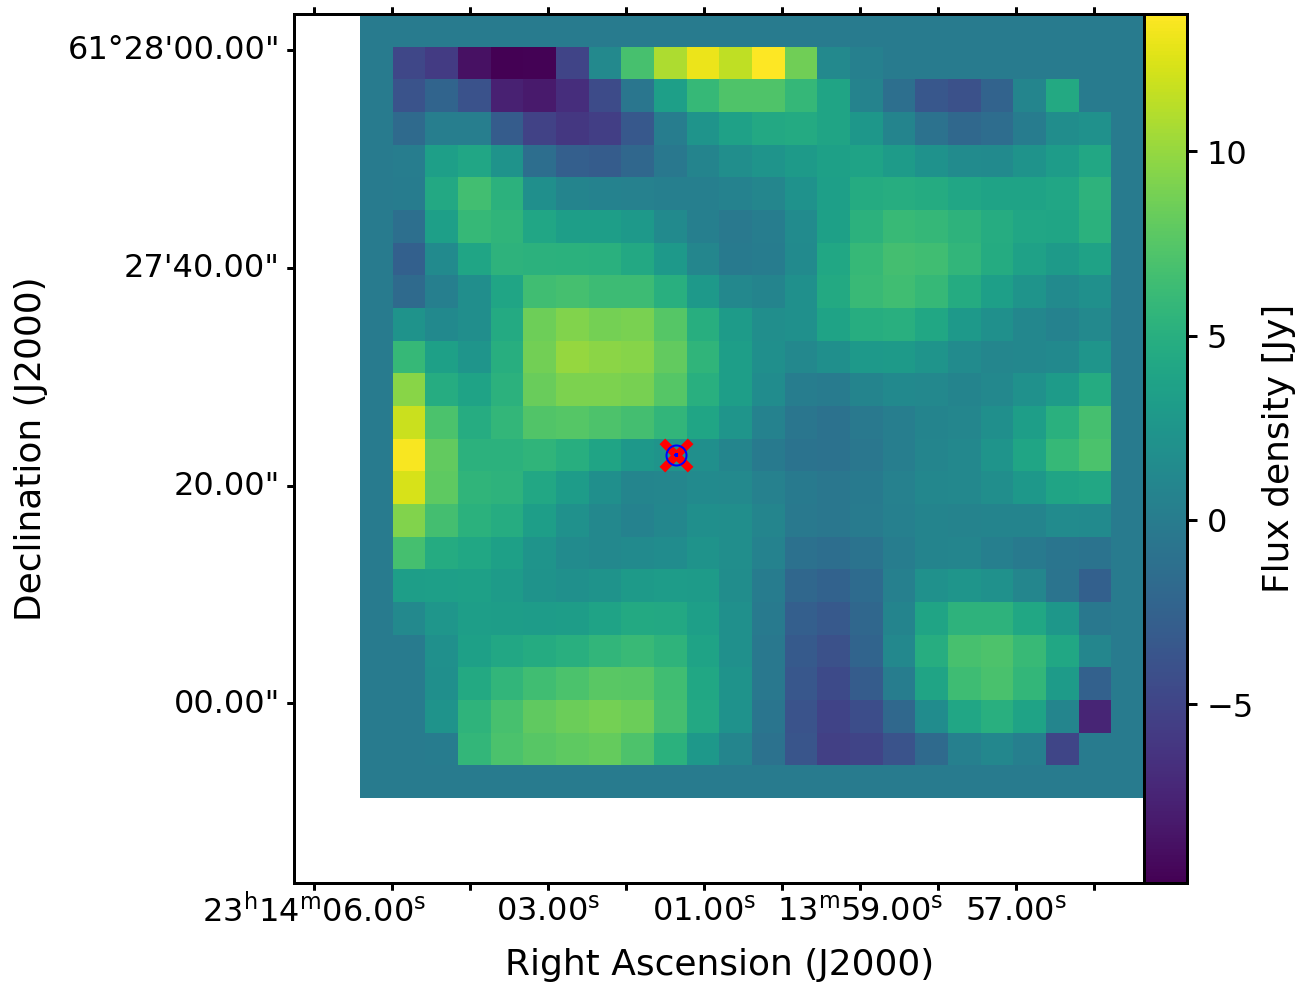

In [141]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from scipy.ndimage import shift

w = WCS(naxis=2)
w.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
w.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
w.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
w.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

s = SkyCoord('23:14:01.77 61:27:19.8', unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

# find where the line is
velo = (wave-line_wave)/line_wave * c/1e5 - v_source
selector = (velo < 150) & (velo > -150)

# make an image with correction to get the extent
contsub_im = np.nansum(contsub_cube[selector,:,:], axis=0)
im = ax.imshow(contsub_im)
extent = im.get_extent()
# reset the extent with astrometric correction
im.set_extent([extent[0]-x_offset_red, extent[1]-x_offset_red, extent[2]-y_offset_red, extent[3]-y_offset_red])

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

# source position
ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

# where the peak of the 2D gaussian supposed to be
ax.errorbar(g.x_mean.value+s_pix[0]-x_offset_red, g.y_mean.value+s_pix[1]-y_offset_red, 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)

cb.ax.set_ylabel('Flux density [Jy]', fontsize=18)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
_ = plt.setp(cb_obj,fontsize=16)

## Flux Measurements - RED

(29, 24, 24) (5, 24, 24)
(24, 24)
57.0
(24, 24)


<ipython-input-149-f0eee9326160>:44: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)


147.08540389275896

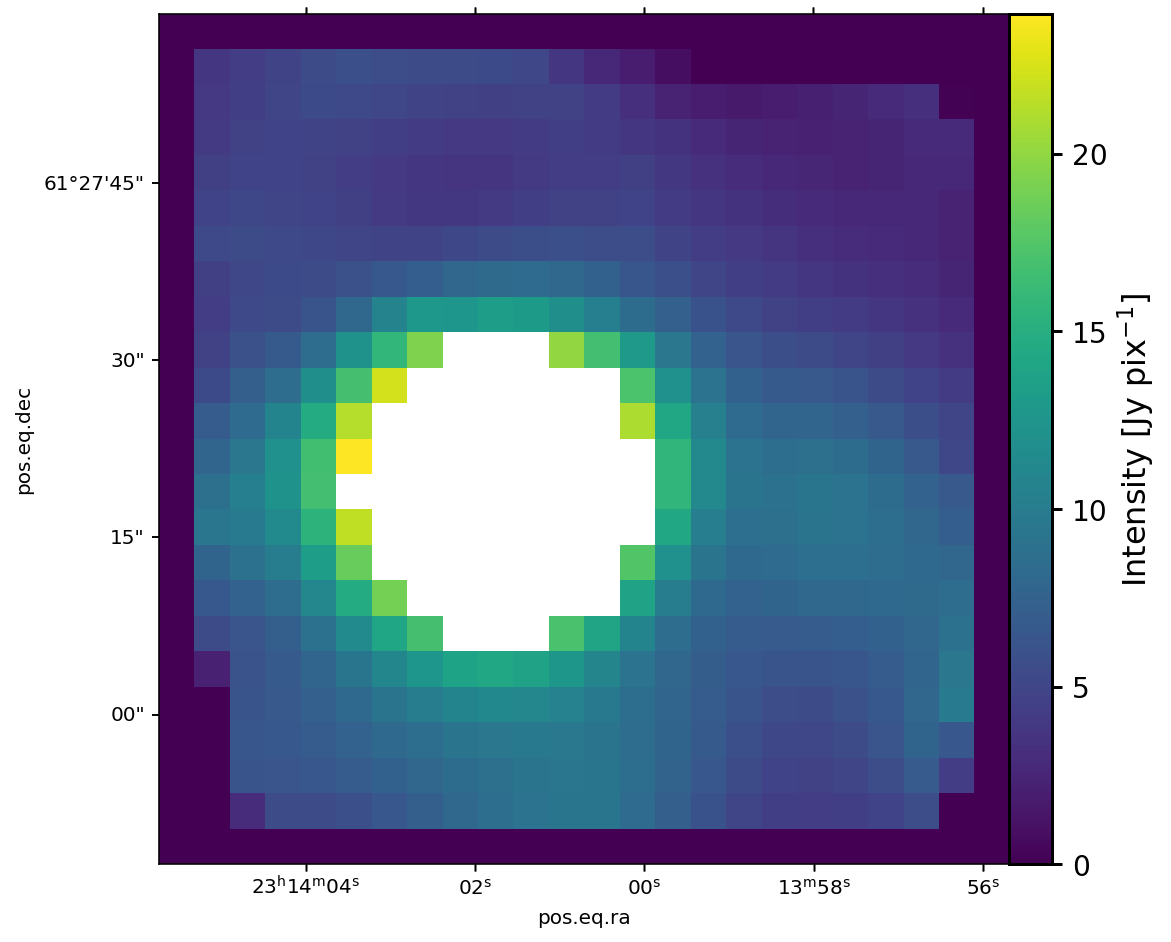

In [149]:
cube = hdu[1].data
wave_RNG1 = [145.07, 145.48]
wave_RNG2 = [145.7, 145.95]

cont_cube1 = cube[(wave >= wave_RNG1[0]) & (wave >= wave_RNG1[1]),:,:]
cont_cube2 = cube[(wave >= wave_RNG2[0]) & (wave >= wave_RNG2[1]),:,:]

print(cont_cube1.shape, cont_cube2.shape)

cont_im_red = (np.nansum(cont_cube1, axis=0) + np.nansum(cont_cube2, axis=0)) / (cont_cube1.shape[0] + cont_cube2.shape[0])

print(cont_im_red.shape)

w = WCS(naxis=2)
w.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
w.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
w.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
w.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

x_grid, y_grid = np.meshgrid(np.arange(len(cont_im_red[0,:])), np.arange(len(cont_im_red[:,0])))

dist_grid = ((x_grid-s_pix[0]-x_offset_red)**2 + (y_grid-s_pix[1]-y_offset_red)**2)**0.5

cont_im_red_mask = np.where((dist_grid <= 25.6/2/3600/abs(hdu[1].header['CDELT1'])), cont_im_red, np.nan)

cont_im_red_bkg = np.where((dist_grid > 25.6/2/3600/abs(hdu[1].header['CDELT1'])), cont_im_red, np.nan)

cont_im_red_pixel = np.nansum(np.where((dist_grid <= 25.6/2/3600/abs(hdu[1].header['CDELT1'])), np.ones_like(cont_im_red), np.nan))

print(cont_im_red_pixel)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection=w)
ax.imshow(cont_im_red_bkg)

cont_im_red = ( np.nansum(cont_cube1, axis=0) + np.nansum(cont_cube2, axis=0) ) / (cont_cube1.shape[0] + cont_cube2.shape[0])
print(cont_im_red.shape)

np.nanstd(cont_im_red_bkg)*cont_im_red_pixel

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)

np.nanmedian(cont_im_red_bkg)*cont_im_red_pixel

<ipython-input-145-0ddd98a53f14>:50: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)


895.7361527950486

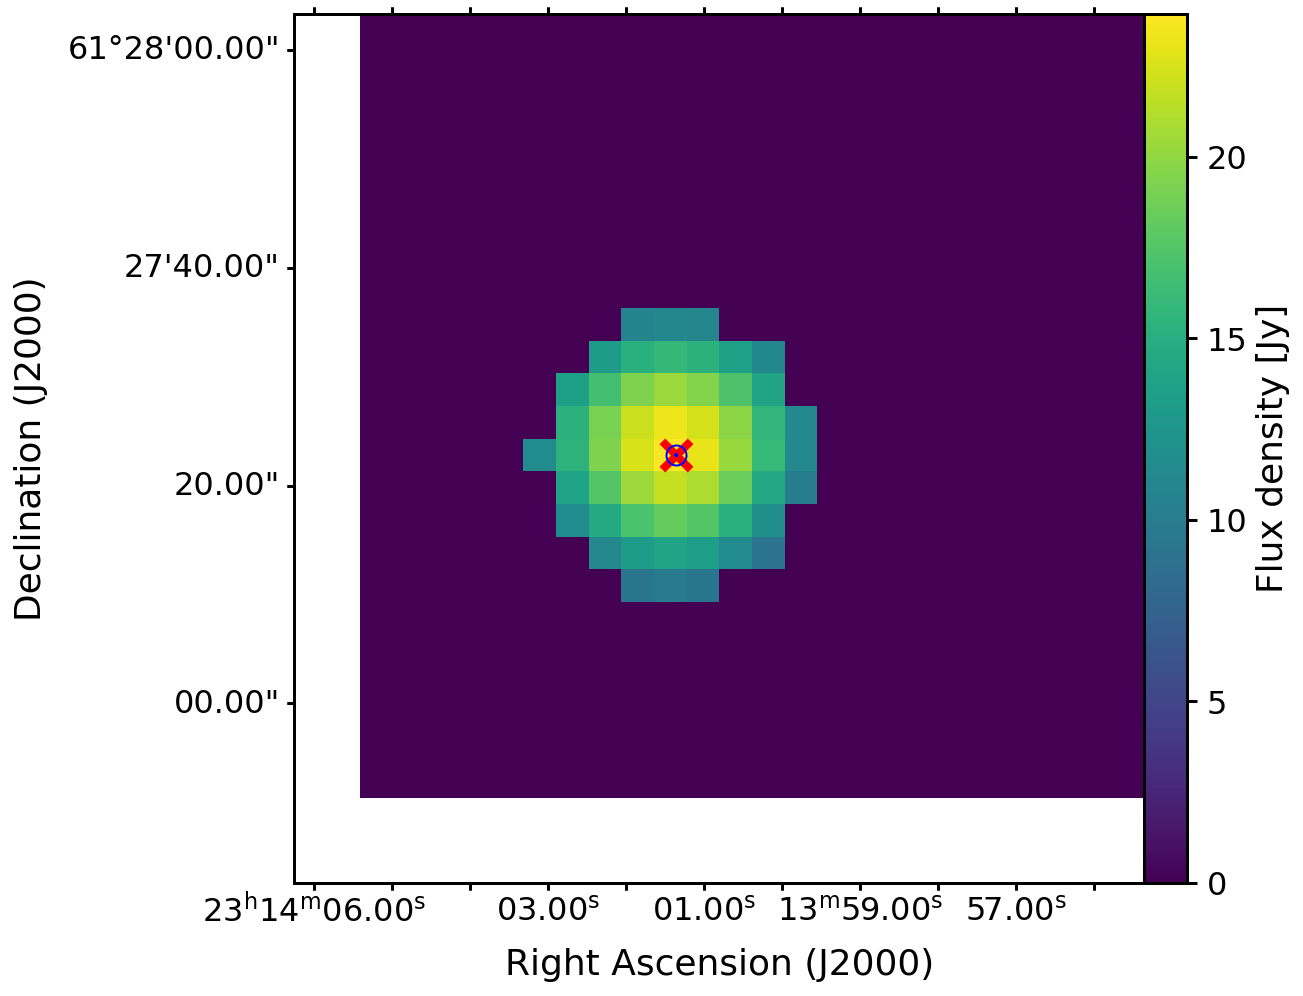

In [145]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from scipy.ndimage import shift

w = WCS(naxis=2)
w.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
w.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
w.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
w.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

s = SkyCoord('23:14:01.77 61:27:19.8', unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

# make an image with correction to get the extent
im = ax.imshow(cont_im_red_mask)
extent = im.get_extent()
# reset the extent with astrometric correction
im.set_extent([extent[0]-x_offset_red, extent[1]-x_offset_red, 
                       extent[2]-y_offset_red, extent[3]-y_offset_red])

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

# source position
ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

# where the peak of the 2D gaussian supposed to be
ax.errorbar(g.x_mean.value+s_pix[0]-x_offset_red, g.y_mean.value+s_pix[1]-y_offset_red, 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)

cb.ax.set_ylabel('Flux density [Jy]', fontsize=18)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
_ = plt.setp(cb_obj,fontsize=16)

np.nansum(np.nansum(cont_im_red_mask, axis=0), axis=0)

<ipython-input-144-ecd40d4bc969>:25: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)


895.7361527950486

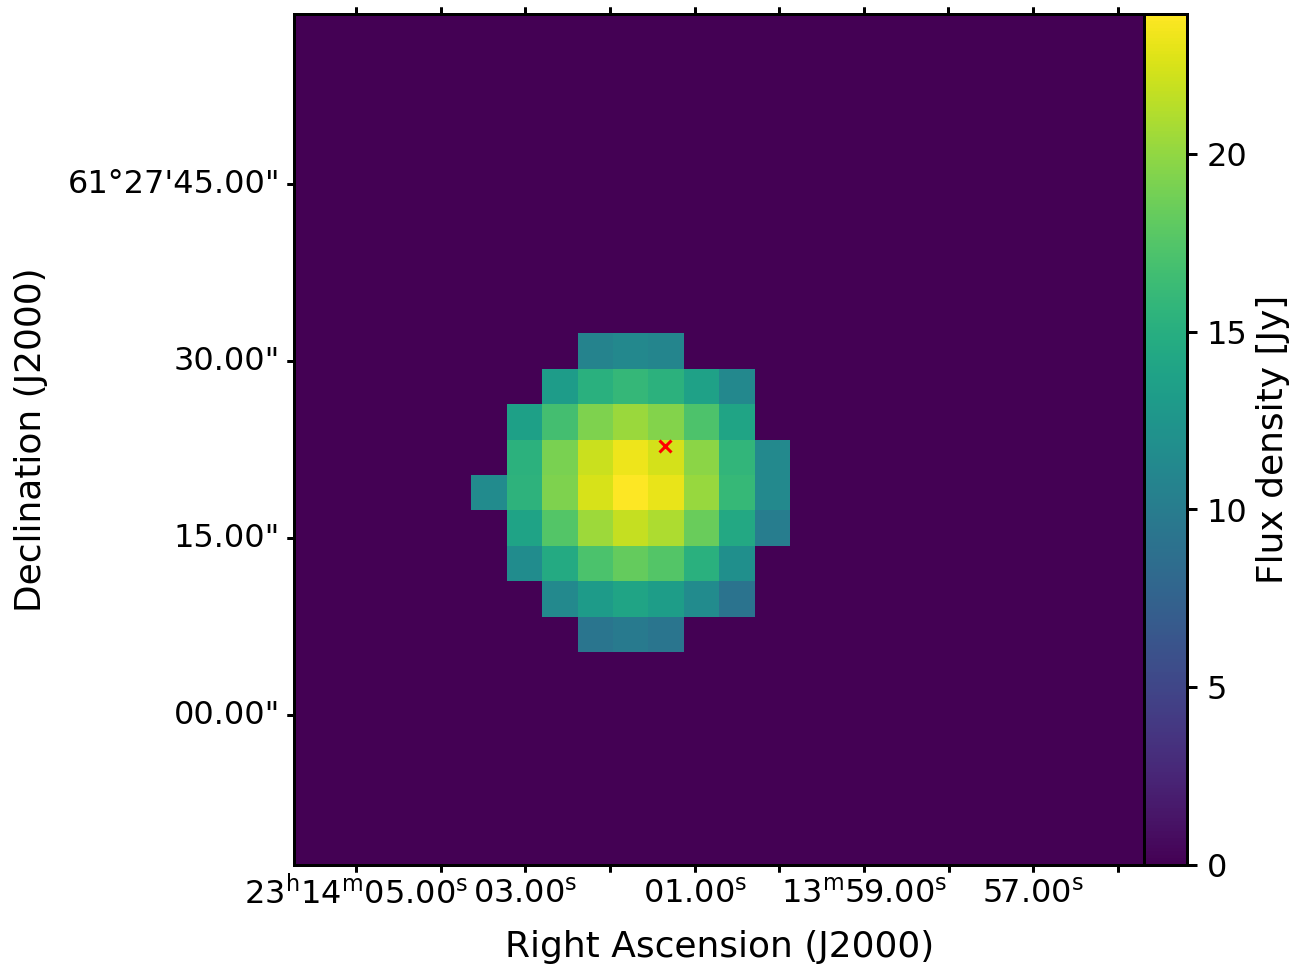

In [144]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

ax.imshow(cont_im_red, cmap='Greys')
im = ax.imshow(cont_im_red_mask)

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

ax.scatter(s_pix[0],s_pix[1], marker='x', color='r')

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)
# cax = fig.add_axes([0.9,0.125,0.03,0.755])
# cb=fig.colorbar(im, cax=cax)
# cb.solids.set_rasterized(True)
# cb.solids.set_edgecolor("face")

cb.ax.set_ylabel('Flux density [Jy]', fontsize=18)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cb_obj,fontsize=16)
np.nansum(np.nansum(cont_im_red_mask, axis=0), axis=0)

# Open the spectral cube - BLUE 63 um

In [153]:
hdu = fits.open('/Users/cassiopeia/Downloads/fits/F0740_FI_IFS_09016939_BLU_WXY_00055-00080.fits')
print (hdu[0].header['OBJECT'], '{:<.1f} um'.format(hdu[1].header['CRVAL3']))

NGC_7538_IRS_9 63.0 um


In [154]:
if abs(hdu[1].header['CRVAL3']-63) < 5:

    cube = hdu[3].data  # redo the transmission correction
    trans = hdu[8].data
    mod_cube = np.zeros_like(cube)
    for i in range(len(cube[:,0,0])):
        mod_cube[i,:,:] = cube[i,:,:]/trans[i]
else:
    mod_cube = hdu[1].data
    trans = hdu[8].data

## 63 um

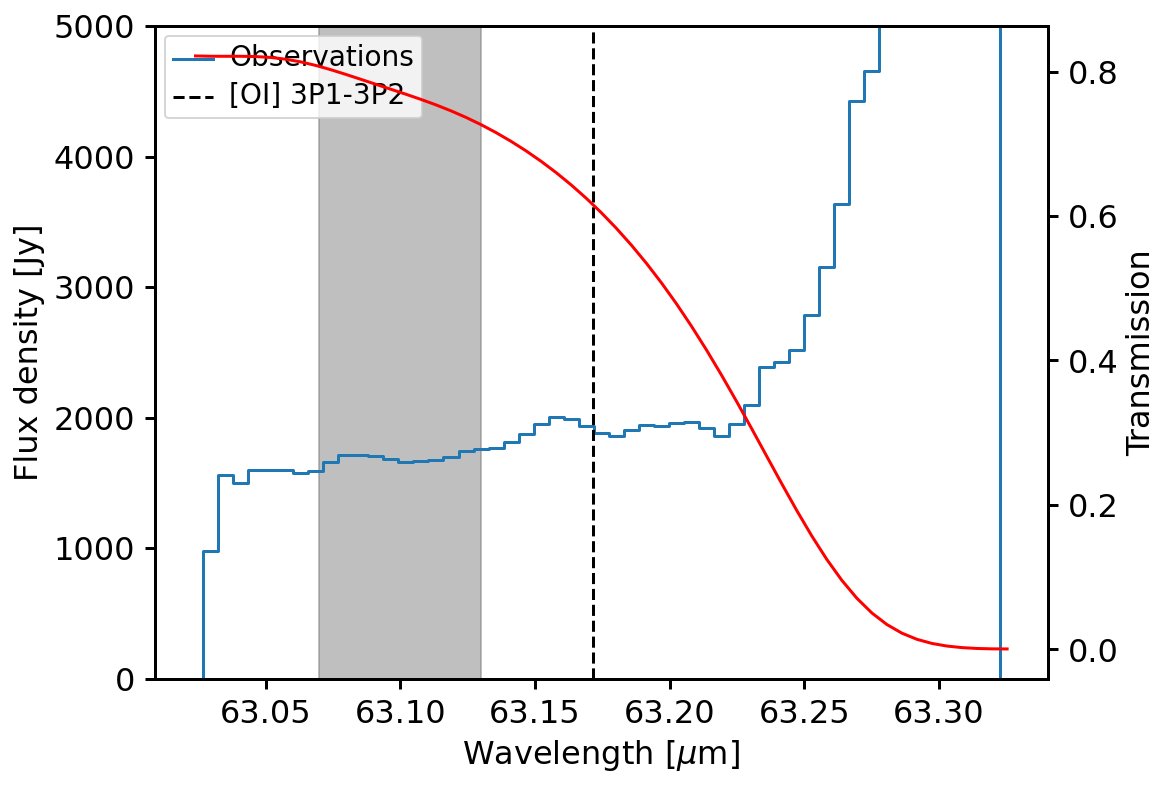

In [155]:
# Construct the flux/wavelength array
wave = ((np.arange(hdu[1].header['NAXIS3'])+1)-hdu[1].header['CRPIX3']) * hdu[1].header['CDELT3'] + hdu[1].header['CRVAL3']

oi_freq = 4.74477749e12
v_source = -57 # km/s (Sandell+2015)
oi_wave = c/oi_freq * 1e4
oi_wave_v_source = oi_wave * (1+v_source/c*1e5)

fig = plt.figure()
ax = fig.add_subplot(111)

n_pixel = mod_cube.shape[1]
ax.plot(wave, np.nansum(np.nansum(mod_cube[:,n_pixel//2-4:n_pixel//2+4, n_pixel//2-4:n_pixel//2+4], axis=1), axis=1), drawstyle='steps-mid', label='Observations')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel('Flux density [Jy]')
ax.axvline(oi_wave_v_source, color='k', linestyle='--', label='[OI] 3P1-3P2')
ax.set_ylim(0, 5000)

# choose the continuum range
ax.fill_betweenx(ax.get_ylim(), 63.07, 63.13, color='Gray', alpha=0.5)
ax.legend(loc='best')
fig, ax = publish(fig)

ax2 = ax.twinx()
ax2.plot(wave, trans, label='Transmission', color='r')
ax2.set_ylabel('Transmission')
fig, ax2 = publish(fig, ax=ax2)

## 63um

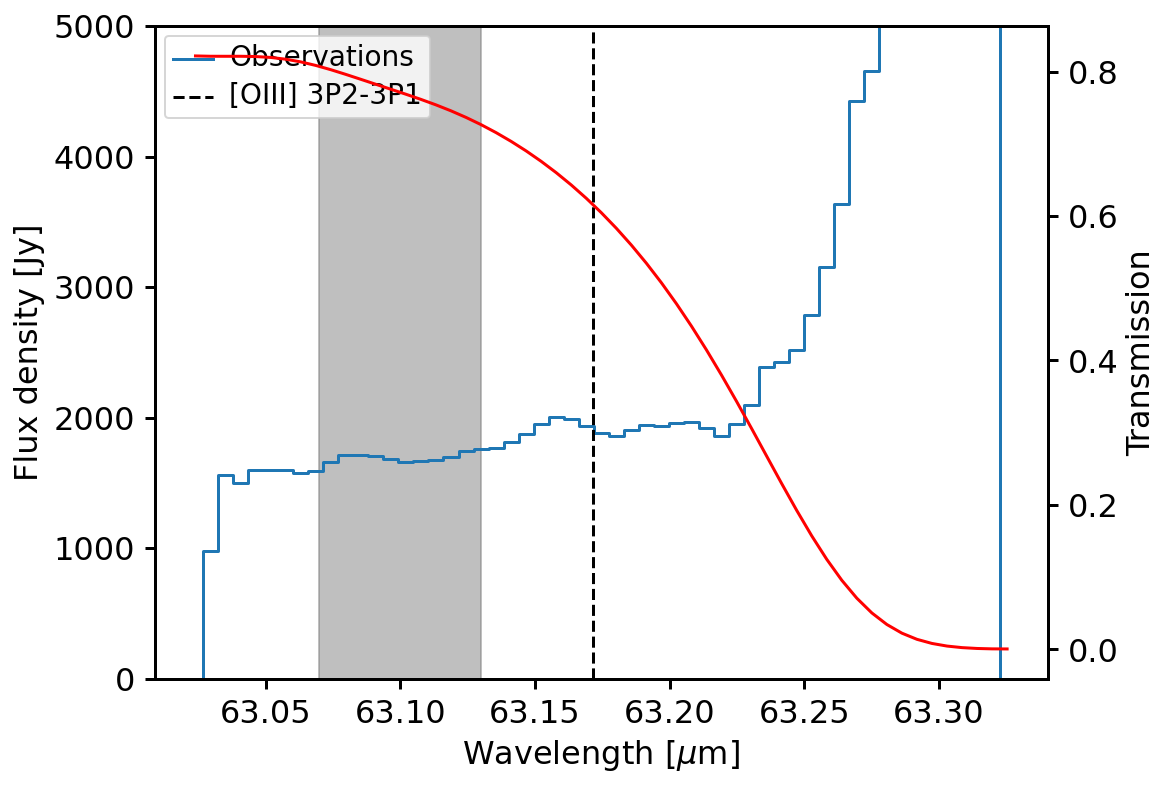

In [156]:
import astropy.constants as const
# Construct the flux/wavelength array
c = const.c.cgs.value
wave = ((np.arange(hdu[1].header['NAXIS3'])+1)-hdu[1].header['CRPIX3']) * hdu[1].header['CDELT3'] + hdu[1].header['CRVAL3']

line_freq = 4.74477749e12
v_source = -57 # km/s (Sandell+2015)
line_wave = (c/line_freq)/1e-4
line_wave_v_source = line_wave * (1+v_source/c*1e5)

fig = plt.figure()
ax = fig.add_subplot(111)

n_pixel = mod_cube.shape[1]
ax.plot(wave, np.nansum(np.nansum(mod_cube[:,n_pixel//2-4:n_pixel//2+4, n_pixel//2-4:n_pixel//2+4], axis=1), axis=1), drawstyle='steps-mid', label='Observations')
ax.set_xlabel(r'Wavelength [$\mu$m]')
ax.set_ylabel('Flux density [Jy]')
ax.axvline(line_wave_v_source, color='k', linestyle='--', label='[OIII] 3P2-3P1')
ax.set_ylim(0, 5000)

# choose the continuum range
ax.fill_betweenx(ax.get_ylim(), 63.07, 63.13, color='Gray', alpha=0.5)
ax.legend(loc='best')
fig, ax = publish(fig)

ax2 = ax.twinx()
ax2.plot(wave, trans, label='Transmission', color='r')
ax2.set_ylabel('Transmission')
fig, ax2 = publish(fig, ax=ax2)

In [157]:
cont_regions = [[63.07, 63.13]] # NGC 7538 IRS9

<div class="alert alert-block alert-info">
Need to double check wuth SOSPEX to see if we can get a line-free spectrum
</div>



# Make continuum (line-free) image

In [158]:
selector = np.zeros_like(wave, dtype='bool')

for _region in cont_regions:
    selector += (wave >= _region[0]) & (wave <= _region[1])
cont_im_blu = np.nanmean(hdu[1].data[selector,:,:], axis=0)

<ipython-input-158-fd23c1720192>:5: RuntimeWarning: Mean of empty slice
  cont_im_blu = np.nanmean(hdu[1].data[selector,:,:], axis=0)


## Continuum image without astrometric correction

<ipython-input-159-09afc4ddd571>:38: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)


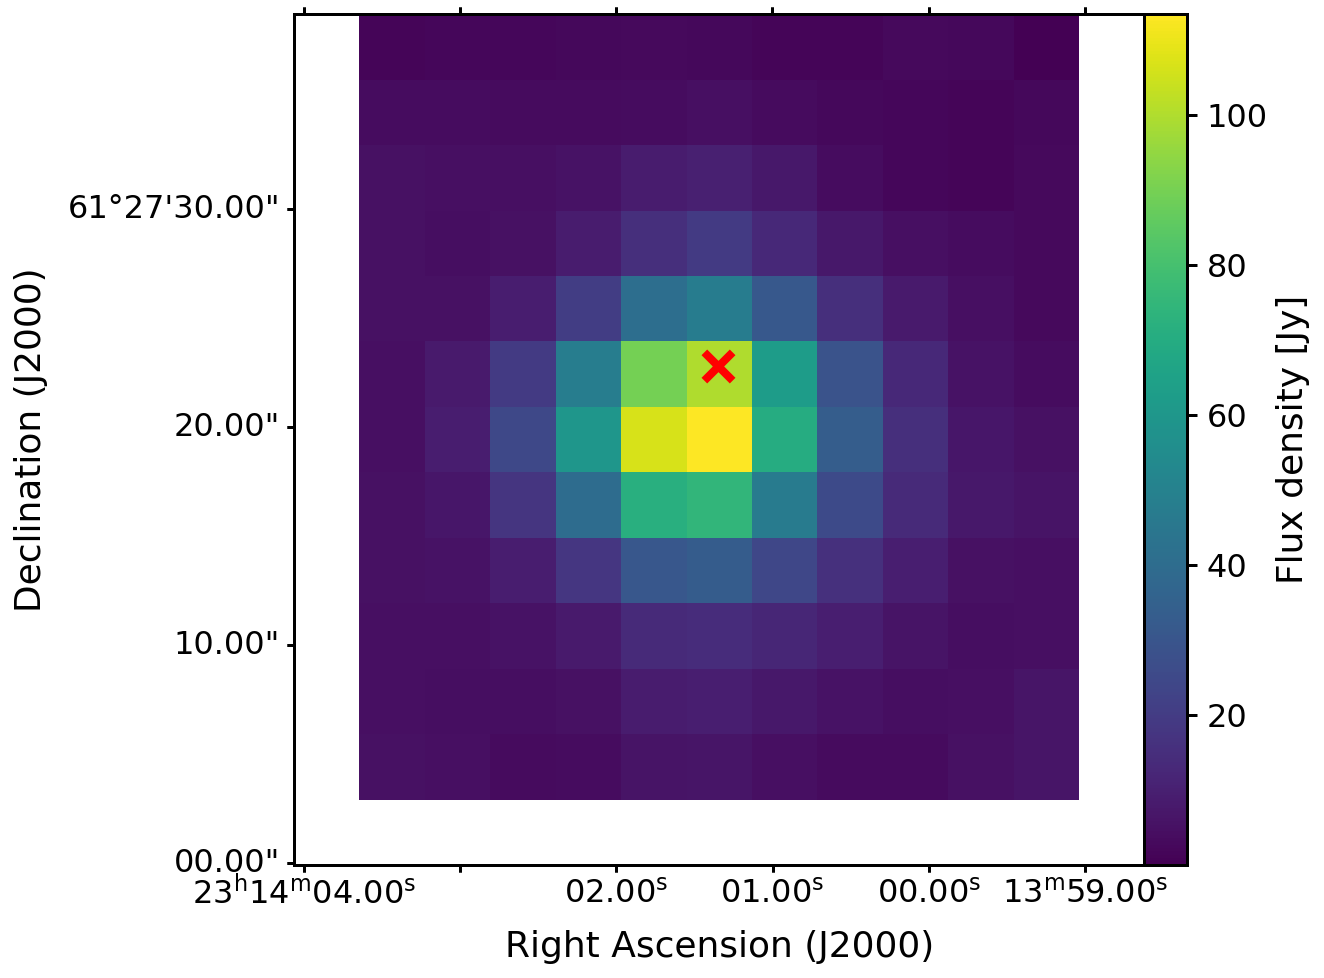

In [159]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS

w = WCS(naxis=2)
w.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
w.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
w.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
w.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

s = SkyCoord('23:14:01.77 61:27:19.8', unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

im = ax.imshow(cont_im_blu)

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)


ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)
# cax = fig.add_axes([0.9,0.125,0.03,0.755])
# cb=fig.colorbar(im, cax=cax)
# cb.solids.set_rasterized(True)
# cb.solids.set_edgecolor("face")

cb.ax.set_ylabel('Flux density [Jy]', fontsize=18)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
_ = plt.setp(cb_obj,fontsize=16)

# Fit with a 2D Gaussian

x_mean = -0.299 +/- 0.007
y_mean = -0.941 +/- 0.007


<ipython-input-160-1cb18166a7d9>:53: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)


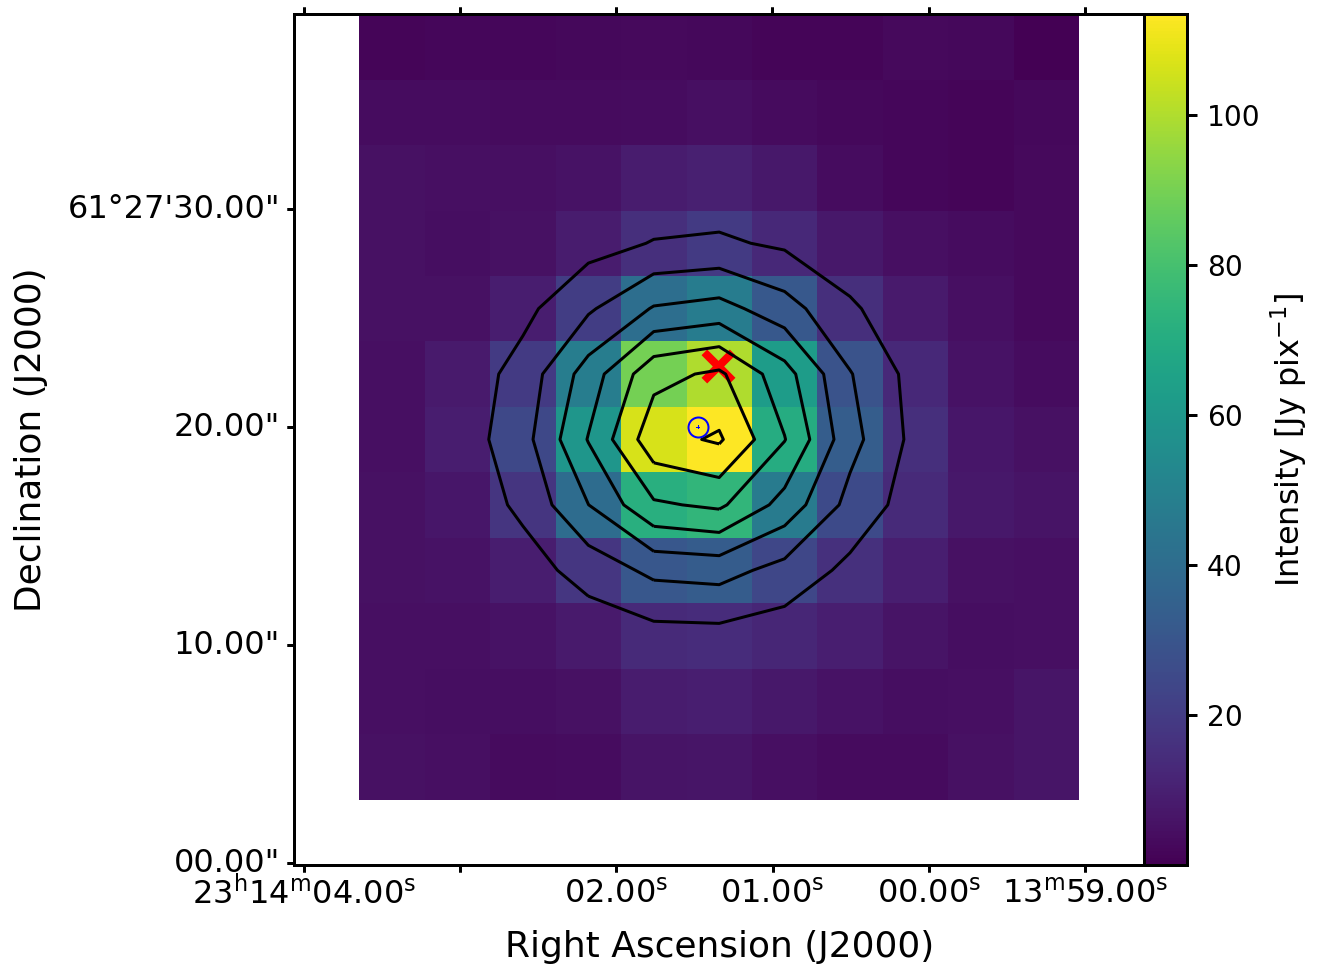

In [160]:
import astropy.io.fits as fits
import os
from astropy.modeling import models, fitting
import matplotlib.pyplot as plt
from matplotlib.patches import Circle 
import matplotlib.axes as maxes
from mpl_toolkits.axes_grid1 import make_axes_locatable

fit = fitting.LevMarLSQFitter()
# initial guess of the fitting parameters
m = models.Gaussian2D(np.nanmax(cont_im_blu), 0, 0, 2, 2)

# Create grids of x- and y-pixels
# Have the source coordinate in here as well, just to be safe
s = SkyCoord('23:14:01.77 61:27:19.8', unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

x_grid, y_grid = np.meshgrid(np.arange(len(cont_im_blu[0,:])), np.arange(len(cont_im_blu[:,0])))
dist_grid = ((x_grid-s_pix[0])**2 + (y_grid-s_pix[1])**2)**0.5
xi = x_grid-s_pix[0]
yi = y_grid-s_pix[1]

# fitting - set NaN value to zero
g = fit(m, xi, yi, np.where(~np.isnan(cont_im_blu), cont_im_blu, 0.0))
# print(g)
print( 'x_mean = {:<.3f} +/- {:<.3f}'.format(g.x_mean.value, fit.fit_info['cov_x'][1,1]**0.5) )
print( 'y_mean = {:<.3f} +/- {:<.3f}'.format(g.y_mean.value, fit.fit_info['cov_x'][2,2]**0.5) )
model_data = g(xi, yi)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

ax.imshow(cont_im_blu)
ax.contour(model_data, colors='k')
ax.errorbar(g.x_mean.value+s_pix[0], g.y_mean.value+s_pix[1], 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)

ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

# Calculate the offset

In [161]:
from astropy.wcs import utils

x_offset_blue, y_offset_blue = [g.x_mean.value, g.y_mean.value] # in pixel
x_offset_err_blue, y_offset_err_blue = [fit.fit_info['cov_x'][1,1]**0.5, fit.fit_info['cov_x'][2,2]**0.5]
pltscale = utils.proj_plane_pixel_scales(w) # width of a pixel in degree
x_offset_blue_arcsec, y_offset_blue_arcsec = [x_offset_blue*pltscale[0]*3600, y_offset_blue*pltscale[0]*3600]
x_offset_err_blue_arcsec, y_offset_err_blue_arcsec = [x_offset_err_blue*pltscale[0]*3600, y_offset_err_blue*pltscale[0]*3600]

# Recall that RA goes from positivie to negative from left to right
print('[BLUE] - Offset in x and y (arcsec, arcsec)   = ({:>5.2f}+/-{:>5.2f}, {:>5.2f}+/-{:>5.2f})'.format(x_offset_blue_arcsec, x_offset_err_blue_arcsec, 
                                                                                    y_offset_blue_arcsec, y_offset_err_blue_arcsec))
print('[RED]  - Offset in x and y (arcsec, arcsec)   = ({:>5.2f}+/-{:>5.2f}, {:>5.2f}+/-{:>5.2f})'.format(x_offset_red_arcsec, x_offset_err_red_arcsec,
                                                                                    y_offset_red_arcsec, y_offset_err_red_arcsec))

# convert the offsets in RED to blue
x_offset_red2blue = x_offset_red_arcsec / (pltscale[0]*3600)
y_offset_red2blue = y_offset_red_arcsec / (pltscale[0]*3600)

print('Relatvie offset in x and y (BLUE from RED)    = ({:>5.2f}+/-{:>5.2f}, {:>5.2f}+/-{:>5.2f})'.format(x_offset_blue_arcsec-x_offset_red_arcsec, 
                                                                                                          (x_offset_err_blue_arcsec**2 + x_offset_err_red_arcsec**2)**0.5,
                                                                                                          y_offset_blue_arcsec-y_offset_red_arcsec,
                                                                                                          (y_offset_err_blue_arcsec**2 + y_offset_err_red_arcsec**2)**0.5))
print('Relatvie offset in RA and Dec (BLUE from RED) = ({:>5.2f}+/-{:>5.2f}, {:>5.2f}+/-{:>5.2f})'.format(-(x_offset_blue_arcsec-x_offset_red_arcsec), 
                                                                                                          (x_offset_err_blue_arcsec**2 + x_offset_err_red_arcsec**2)**0.5,
                                                                                                          y_offset_blue_arcsec-y_offset_red_arcsec,
                                                                                                          (y_offset_err_blue_arcsec**2 + y_offset_err_red_arcsec**2)**0.5))

print('IF we consider the 1/3 beam size error - ')
# 14 x (1.9/ v THz)
red_beam = 14 * (1.9/1.6) / 3 # 185 um (CO 14-13)
blue_beam = 14 * (1.9/5.8) / 3 # 52 um ([OIII])
print('Relatvie offset in x and y (BLUE from RED)    = ({:>5.2f}+/-{:>5.2f}, {:>5.2f}+/-{:>5.2f})'.format(x_offset_blue_arcsec-x_offset_red_arcsec, 
                                                                                                          (x_offset_err_blue_arcsec**2 + x_offset_err_red_arcsec**2 + blue_beam**2 + red_beam**2)**0.5,
                                                                                                          y_offset_blue_arcsec-y_offset_red_arcsec,
                                                                                                          (y_offset_err_blue_arcsec**2 + y_offset_err_red_arcsec**2 + blue_beam**2 + red_beam**2)**0.5))


[BLUE] - Offset in x and y (arcsec, arcsec)   = (-0.90+/- 0.02, -2.82+/- 0.02)
[RED]  - Offset in x and y (arcsec, arcsec)   = (-2.37+/- 0.12, -3.98+/- 0.11)
Relatvie offset in x and y (BLUE from RED)    = ( 1.48+/- 0.12,  1.16+/- 0.11)
Relatvie offset in RA and Dec (BLUE from RED) = (-1.48+/- 0.12,  1.16+/- 0.11)
IF we consider the 1/3 beam size error - 
Relatvie offset in x and y (BLUE from RED)    = ( 1.48+/- 5.75,  1.16+/- 5.75)


## Continuum image WITH astrometric correction

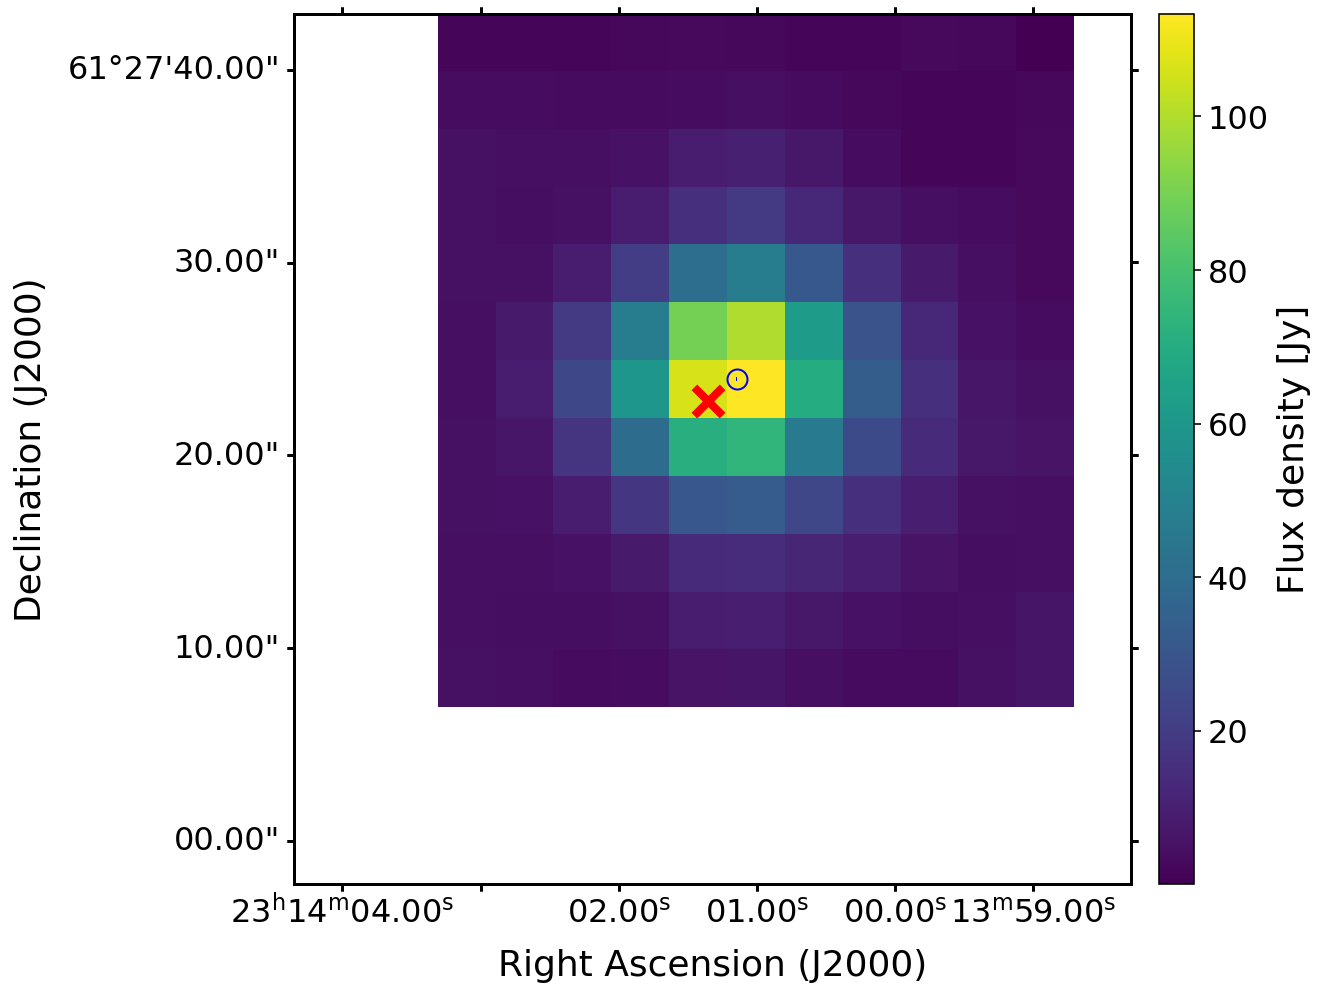

In [162]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from scipy.ndimage import shift

w = WCS(naxis=2)
w.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
w.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
w.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
w.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

s = SkyCoord('23:14:01.77 61:27:19.8', unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

# make an image with correction to get the extent
im = ax.imshow(cont_im_blu)
extent = im.get_extent()
# actual image with astrometric correction
im.set_extent([extent[0]-x_offset_red, extent[1]-x_offset_red, extent[2]-y_offset_red, extent[3]-y_offset_red])

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

# source position
ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

# where the peak of the 2D gaussian supposed to be
ax.errorbar(g.x_mean.value+s_pix[0]-x_offset_red, g.y_mean.value+s_pix[1]-y_offset_red, 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)


cax = fig.add_axes([0.9,0.125,0.03,0.755])
cb=fig.colorbar(im, cax=cax)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")

cb.ax.set_ylabel('Flux density [Jy]', fontsize=18)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
_ = plt.setp(cb_obj,fontsize=16)

# Make cont-free spectral cube

In [163]:
# cube = hdu[3].data  # redo the transmission correction
contsub_cube = np.zeros_like(mod_cube)
for i in range(len(mod_cube[:,0,0])):
    contsub_cube[i,:,:] = mod_cube[i,:,:] - cont_im_blu

<ipython-input-164-1c038f660add>:53: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)


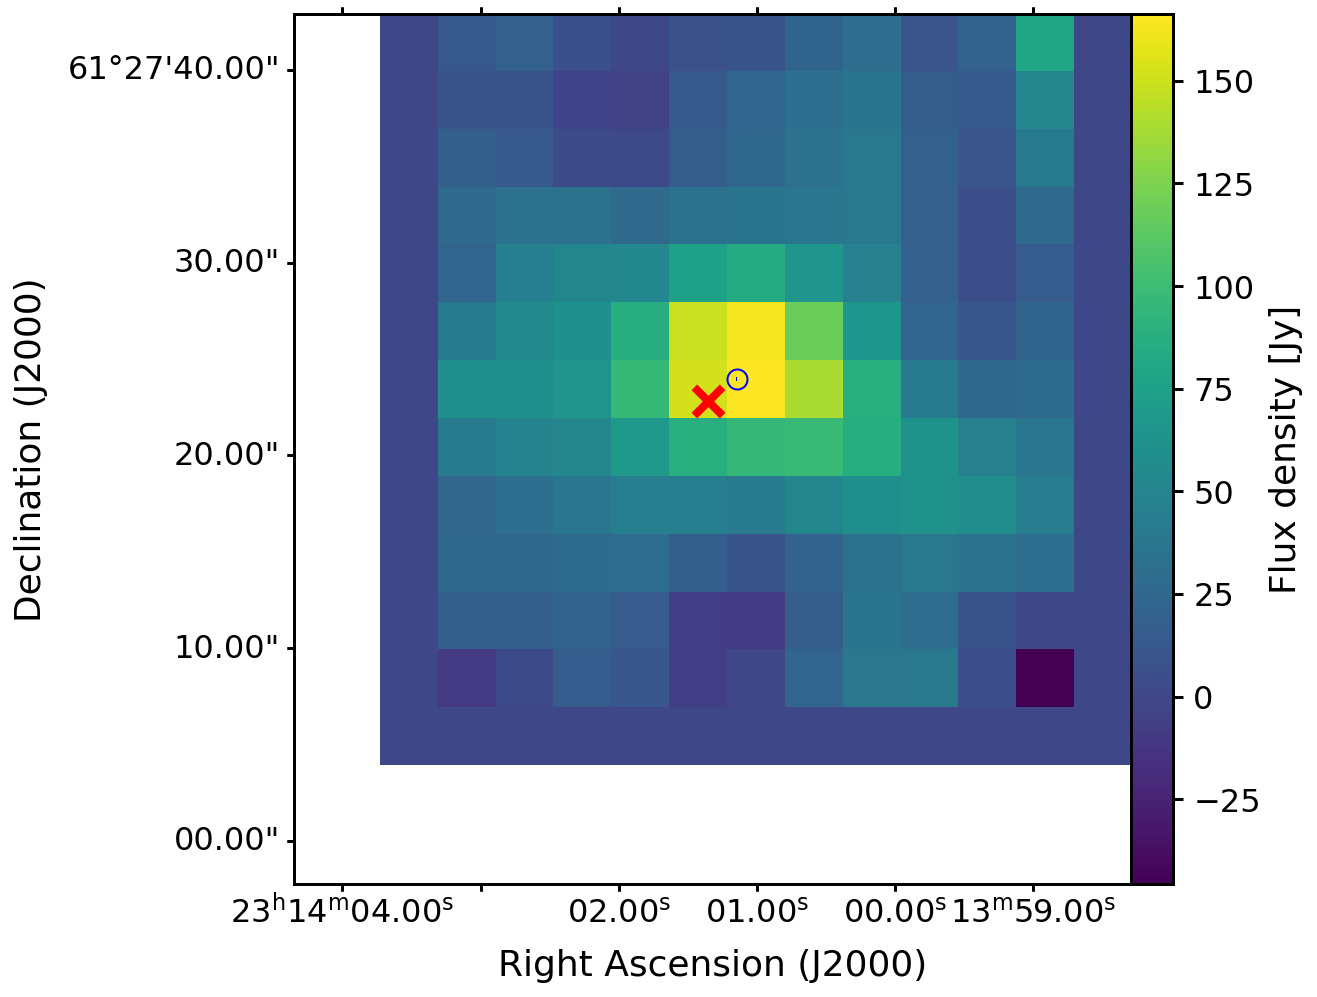

In [164]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
from scipy.ndimage import shift

w = WCS(naxis=2)
w.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
w.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
w.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
w.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

s = SkyCoord('23:14:01.77 61:27:19.8', unit=(u.hourangle, u.degree), equinox='J2000') 
s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

# find where the line is
velo = (wave-line_wave)/line_wave * c/1e5 - v_source
selector = (velo < 150) & (velo > -150)

# make an image with correction to get the extent
contsub_im = np.nansum(contsub_cube[selector,:,:], axis=0)
im = ax.imshow(contsub_im)
extent = im.get_extent()
# actual image with astrometric correction
im.set_extent([extent[0]-x_offset_red, extent[1]-x_offset_red, extent[2]-y_offset_red, extent[3]-y_offset_red])

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

# source position
ax.scatter(s_pix[0], s_pix[1], marker='x', color='r', s=200, linewidth=4)

# where the peak of the 2D gaussian supposed to be
ax.errorbar(g.x_mean.value+s_pix[0]-x_offset_red, g.y_mean.value+s_pix[1]-y_offset_red, 
            xerr=fit.fit_info['cov_x'][1,1]**0.5, yerr=fit.fit_info['cov_x'][2,2]**0.5,
            color='b', marker='o', markersize=10, elinewidth=2, mfc='None')

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)
# cax = fig.add_axes([0.9,0.125,0.03,0.755])
# cb=fig.colorbar(im, cax=cax)
# cb.solids.set_rasterized(True)
# cb.solids.set_edgecolor("face")

cb.ax.set_ylabel('Flux density [Jy]', fontsize=18)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
_ = plt.setp(cb_obj,fontsize=16)

## Flux Measurements - BLU

(36, 13, 13) (36, 13, 13)
(13, 13)
59.0
(13, 13)


<ipython-input-168-6baea53dbcf9>:44: MatplotlibDeprecationWarning: In a future version, 'pad' will default to rcParams['figure.subplot.wspace'].  Set pad=0 to keep the old behavior.
  cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)


98.57372376228241

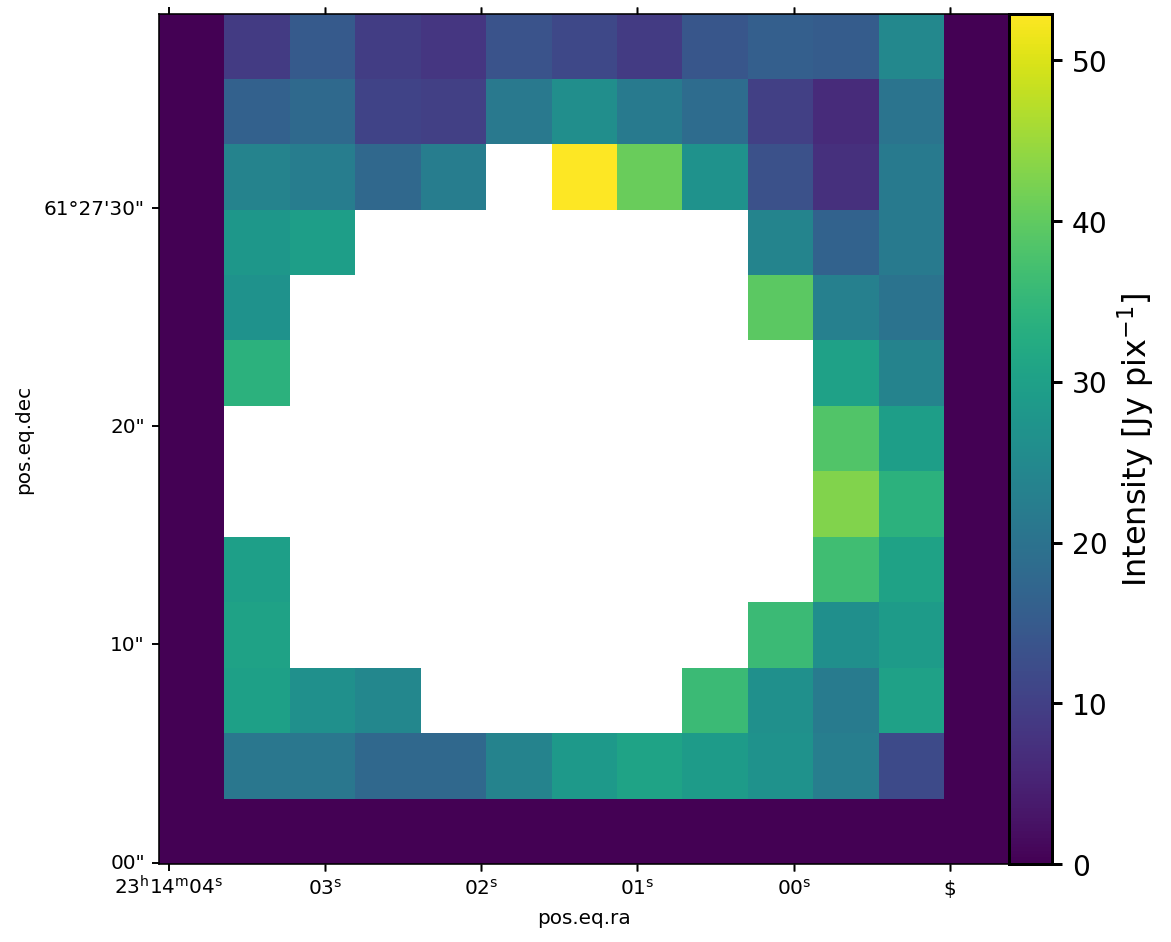

In [168]:
cube = hdu[1].data
wave_RNG1 = [63.07, 63.13]
wave_RNG2 = [63.07, 63.13]

cont_cube1 = cube[(wave >= wave_RNG1[0]) & (wave >= wave_RNG1[1]),:,:]
cont_cube2 = cube[(wave >= wave_RNG2[0]) & (wave >= wave_RNG2[1]),:,:]

print(cont_cube1.shape, cont_cube2.shape)

cont_im_blu = (np.nansum(cont_cube1, axis=0) + np.nansum(cont_cube2, axis=0)) / (cont_cube1.shape[0] + cont_cube2.shape[0])

print(cont_im_blu.shape)

w = WCS(naxis=2)
w.wcs.crpix = [hdu[1].header['CRPIX1'], hdu[1].header['CRPIX2']]
w.wcs.cdelt = np.array([hdu[1].header['CDELT1'], hdu[1].header['CDELT2']])
w.wcs.crval = [hdu[1].header['CRVAL1'], hdu[1].header['CRVAL2']]
w.wcs.ctype = [hdu[1].header['CTYPE1'], hdu[1].header['CTYPE2']]

s_pix = w.wcs_world2pix(s.ra.degree, s.dec.degree, 1)

x_grid, y_grid = np.meshgrid(np.arange(len(cont_im_blu[0,:])), np.arange(len(cont_im_blu[:,0])))

dist_grid = ((x_grid-s_pix[0]-x_offset_red)**2 + (y_grid-s_pix[1]-y_offset_red)**2)**0.5

cont_im_blu_mask = np.where((dist_grid <= 25.6/2/3600/abs(hdu[1].header['CDELT1'])), cont_im_blu, np.nan)

cont_im_blu_bkg = np.where((dist_grid > 25.6/2/3600/abs(hdu[1].header['CDELT1'])), cont_im_blu, np.nan)

cont_im_blu_pixel = np.nansum(np.where((dist_grid <= 25.6/2/3600/abs(hdu[1].header['CDELT1'])), np.ones_like(cont_im_blu), np.nan))

print(cont_im_blu_pixel)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111,projection=w)
ax.imshow(cont_im_blu_bkg)

cont_im_blu = ( np.nansum(cont_cube1, axis=0) + np.nansum(cont_cube2, axis=0) ) / (cont_cube1.shape[0] + cont_cube2.shape[0])
print(cont_im_blu.shape)

np.nanstd(cont_im_blu_bkg)*cont_im_blu_pixel

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", axes_class=maxes.Axes)
cb = fig.colorbar(im, cax=cax)
cb.ax.yaxis.label.set_fontsize(16)
cb.ax.set_ylabel('Intensity [Jy pix$^{-1}$]')
cb.ax.tick_params('both', labelsize=14,  width=1.5, which='major', pad=5, length=5)
cb.outline.set_linewidth(1.5)

np.nanmedian(cont_im_blu_bkg)*cont_im_blu_pixel

771.8544215167998

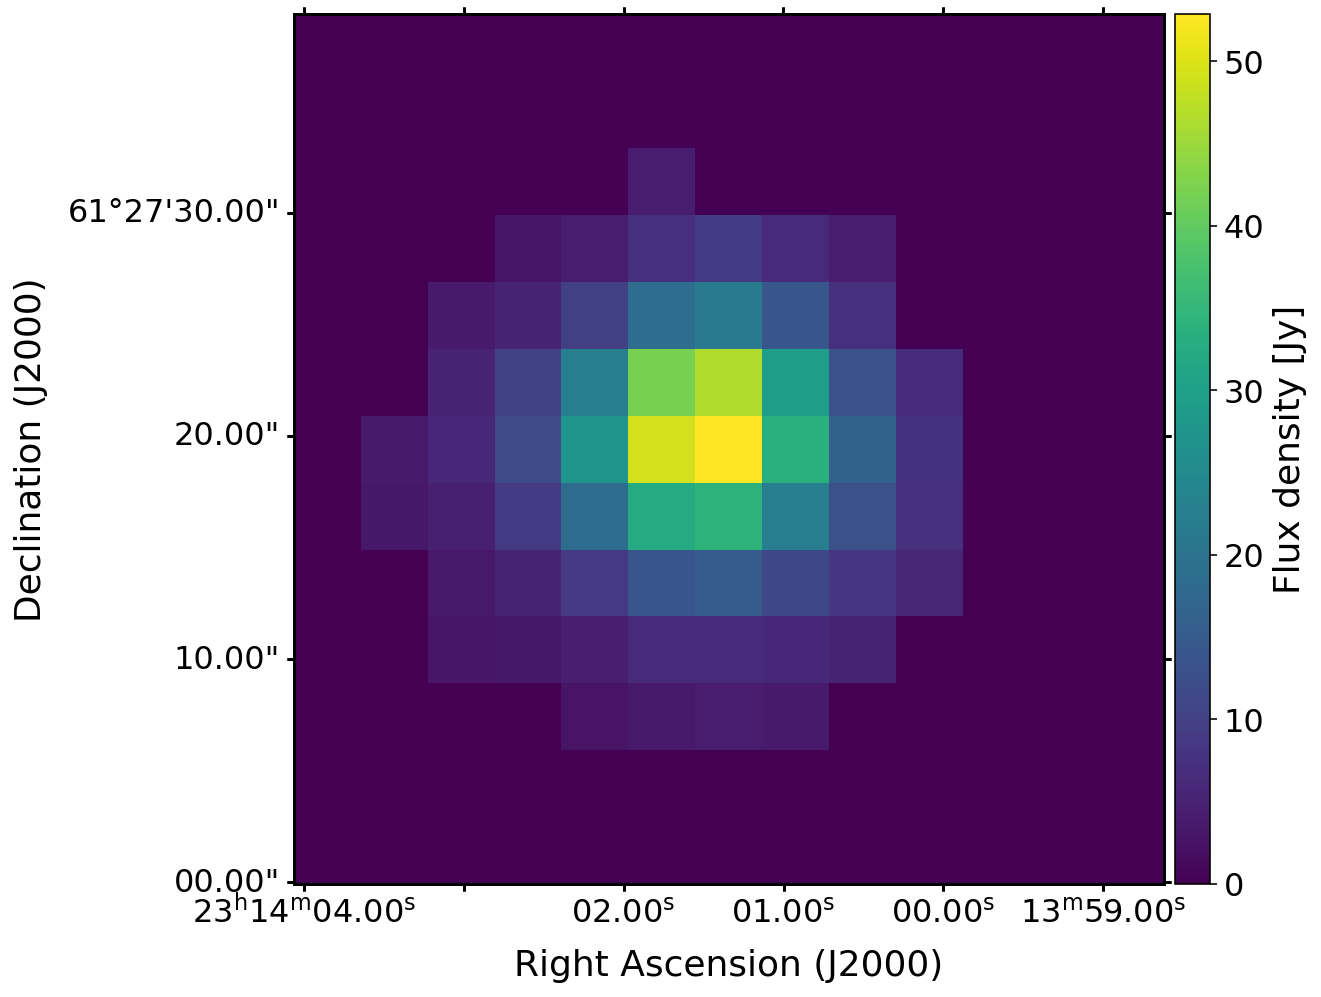

In [166]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=w)

ax.imshow(cont_im_blu, cmap='Greys')
im = ax.imshow(cont_im_blu_mask)

ax.set_xlabel('R.A. [deg]', fontsize=16)
ax.set_ylabel('Dec. [deg.]', fontsize=16)

#ax.scatter(s_pix[0],s_pix[1], marker='x', color='r')

ax.coords[0].set_major_formatter('hh:mm:ss.ss')
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=18)
ax.coords[0].set_ticklabel(fontsize=16)
ax.coords[0].set_ticks (width=1.5, spacing=15. * u.arcsec, exclude_overlapping=True)
ax.coords[1].set_major_formatter('dd:mm:ss.ss')
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=18)
ax.coords[1].set_ticklabel(fontsize=16)
ax.coords[1].set_ticks(width=1.5)
ax.coords.frame.set_linewidth(1.5)


cax = fig.add_axes([0.9,0.125,0.03,0.755])
cb=fig.colorbar(im, cax=cax)
cb.solids.set_rasterized(True)
cb.solids.set_edgecolor("face")

cb.ax.set_ylabel('Flux density [Jy]', fontsize=18)
cb_obj = plt.getp(cb.ax.axes, 'yticklabels')
plt.setp(cb_obj,fontsize=16)

np.nansum(np.nansum(cont_im_blu_mask, axis=0), axis=0)